In [2]:
!pip install fredapi

In [3]:
import pandas as pd
import numpy as np
from fredapi import Fred
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

fred = Fred(api_key='2762cecd3d02ff4b96df9a6049d8daf4')

start_date = '1992-01-01'
end_date = '2023-03-31'

# Define the series IDs
series_ids = {
    # Treatment and Outcome
    'yield_curve': 'T10Y2Y',                             # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (daily)
    'real_gdp': 'external source',                       # S&P 500 Real GDP Monthly Estimates (monthly) https://www.spglobal.com/marketintelligence/en/mi/products/us-monthly-gdp-index.html

    # Potential Confounders
    'real_cpe': 'DPCERAM1M225NBEA',                      # Month/Month % Change in personal consumption expenditures (pce)
    'unemployment_rate': 'UNRATE',                       # Unemployment Rate (monthly and seasonally adjusted)
    'federal_funds_rate': 'FEDFUNDS',                    # Federal Funds Effective Rate (monthly and not seasonally adjusted)
    'sticky_cpi': 'CORESTICKM157SFRBATL',                # Sticky Price Consumer Price Index less Food and Energy (month over month % change and seasonally adjusted)
    'us_policy_uncertainty': 'external source',          # US Policy Uncertainty (monthly) https://www.policyuncertainty.com/us_monthly.html
    'geopolitical risk index': 'external source',        # Data of the geopolitical risk index (monthly) https://www.policyuncertainty.com/gpr.html
    'cboe_volatility': 'VIXCLS',                         # CBOE Volatility Index: VIX (daily)
    'business_confidence': 'BSCICP03USM665S',            # Business Confidence Index (monthly and seasonally adjusted)
    'consumer_confidence': 'CSCICP03USM665S',            # Consumer Confidence Index (monthly and seasonally adjusted)
}
series_freq = {
    # Treatment and Outcome
    'yield_curve': 'daily',
    'real_gdp': 'monthly',

    # Potential Confounders
    'real_cpe': 'monthly',
    'unemployment_rate': 'monthly',
    'federal_funds_rate': 'monthly',
    'sticky_cpi': 'monthly',
    'us_policy_uncertainty': 'monthly',
    'geopolitical risk index': 'monthly',
    'cboe_volatility': 'daily',
    'business_confidence': 'monthly',
    'consumer_confidence': 'monthly',
}

# Create an empty DataFrame to store the data
df = pd.DataFrame()

# Iterate over each series ID and fetch the data
for series_name, series_id in series_ids.items():

    # Extract series values from designated source
    if series_name == 'real_gdp':
      file_path = "US-Monthly-GDP-History-Data.xlsx"
      data = pd.read_excel(file_path, sheet_name="Data")
      data.reset_index(inplace=True)
      data.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
      data["Date"] = pd.to_datetime(data["Date"], format='mixed')
      data.set_index("Date", inplace=True)                           # Set the index to the dates column
      data.index = data.index + pd.offsets.MonthEnd(0)               # Make the dates the last day of each month
      data = data["Monthly Real GDP Index"]

    elif series_name == 'us_policy_uncertainty':
      file_path = "US_Policy_Uncertainty_Data.xlsx"
      data = pd.read_excel(file_path, sheet_name="Main Index")
      data = data.iloc[:-1]                                          # Remove the last row attribution
      data["Date"] = pd.to_datetime(data[['Year', 'Month']].assign(day=1))
      data.set_index("Date", inplace=True)
      data.index = data.index + pd.offsets.MonthEnd(0)
      data = data["News_Based_Policy_Uncert_Index"]

    elif series_name == 'geopolitical risk index':
      file_path = "data_gpr_export.xls"
      data = pd.read_excel(file_path, sheet_name="Sheet1")
      data["Date"] = pd.to_datetime(data['month'], format="%m/%d/%Y")
      data.set_index("Date", inplace=True)
      data.index = data.index + pd.offsets.MonthEnd(0)
      data = data["GPR"]

    else:
      data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)

    if series_name == 'yield_curve':
      data = data.interpolate(method='linear')                                  # Interpolate yield curve data to fill in missing values
      data = data.apply(lambda x: 1 if x <= 0 else 0)                           # Convert it to binary indicator values based on inversions
      data = data.resample('M').max()                                           # Get the maximum indicatoe value in a month and use that
      conditions = [(data.shift(i).fillna(0) == 0) for i in range(1, 6 + 1)]    # Check that there were no inversions in the last 6 months leading up to this one
      combined_condition = pd.concat(conditions, axis=1).all(axis=1)
      positive_values_condition = (data == 1)                                   # Also check that the current month does have an inversion
      final_condition = positive_values_condition & combined_condition          # Get the indices that meet these conditions
      indices = final_condition[final_condition].index
      df["YC_INV"] = data
      df["YC_INV"] = 0                                                          # Initialize all values to 0
      df.loc[df.index.isin(indices), "YC_INV"] = 1                              # Assign 1 to the specified dates
      continue
    elif series_name == 'sticky_cpi':
      data.index = pd.to_datetime(data.index)
      data.index = data.index.to_period('M').to_timestamp('M') + pd.offsets.MonthEnd(0)
      df["M/M%_CPI"] = 1 + data/100
    elif series_name == 'real_cpe':
      data.index = pd.to_datetime(data.index)
      data.index = data.index.to_period('M').to_timestamp('M') + pd.offsets.MonthEnd(0)
      df["M/M%_RCPE"] = 1 + data/100
    else:
      data.index = data.index + pd.offsets.MonthEnd(0)
      if series_freq[series_name] == "daily":
        data = data.interpolate(method='linear')
        data = data.resample('M').mean()

      data = 1 + data.pct_change()
      df[series_name] = data.ffill()

df = df[df.index >= '1992-02-01']

# Take the natural logarithm of values in the specified columns
for column in df.columns:
  if column != "YC_INV":
    df[column] = np.log(df[column])

# Everything is log % changes except YC Inversions
print(df.head())

C:\Users\ellac\AppData\Local\Temp\ipykernel_21420\1399134299.py:86: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').max()                                           # Get the maximum indicatoe value in a month and use that


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [ ]:
# Calculate the mean of each column
means = df.mean()

# Calculate the standard deviation of each column
std_devs = df.std()

print(means)
print(std_devs)

YC_INV                     0.013369
real_gdp                   0.002074
M/M%_RCPE                  0.002278
unemployment_rate         -0.001966
federal_funds_rate         0.000383
M/M%_CPI                   0.002193
us_policy_uncertainty      0.001455
geopolitical risk index    0.000067
cboe_volatility            0.000540
business_confidence       -0.000013
consumer_confidence       -0.000016
dtype: float64
YC_INV                     0.115003
real_gdp                   0.008616
M/M%_RCPE                  0.009583
unemployment_rate          0.071889
federal_funds_rate         0.204015
M/M%_CPI                   0.001025
us_policy_uncertainty      0.261288
geopolitical risk index    0.226007
cboe_volatility            0.163498
business_confidence        0.002394
consumer_confidence        0.002264
dtype: float64


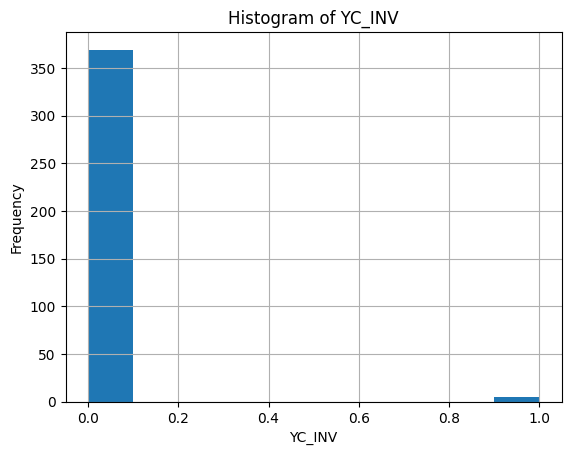

In [ ]:
# Plot histogram
df["YC_INV"].hist()

# Add labels and title
plt.xlabel("YC_INV")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "YC_INV")

# Show plot
plt.show()

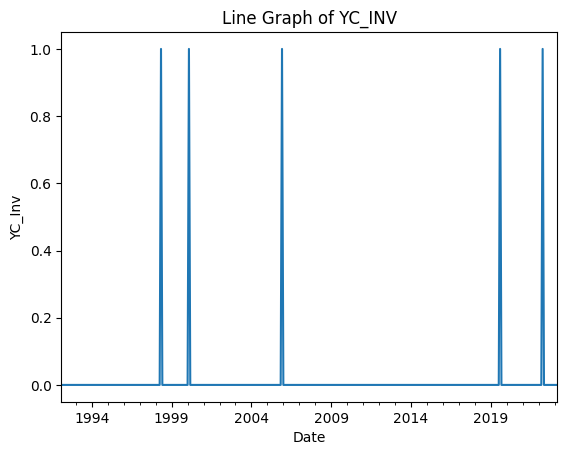

In [ ]:
# Plot histogram
df["YC_INV"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('YC_Inv')
plt.title('Line Graph of ' + "YC_INV")

# Show plot
plt.show()

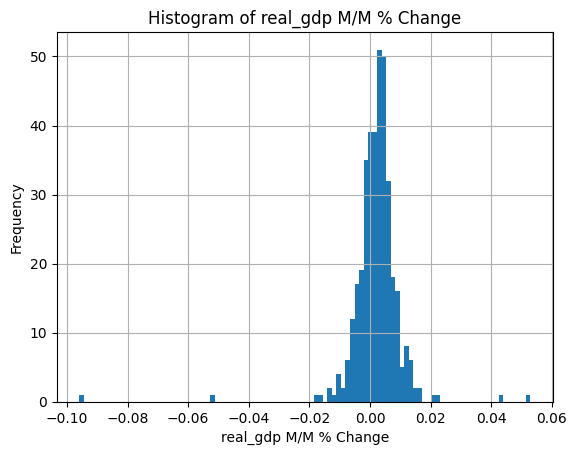

In [ ]:
# Plot histogram
df["real_gdp"].hist(bins=100)

# Add labels and title
plt.xlabel("real_gdp M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "real_gdp M/M % Change")

# Show plot
plt.show()

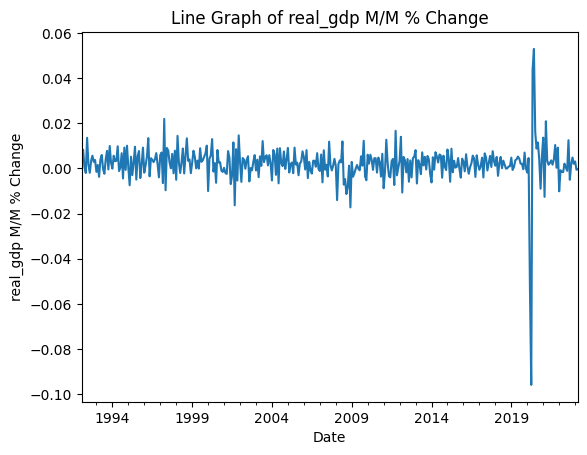

In [ ]:
# Plot histogram
df["real_gdp"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('real_gdp M/M % Change')
plt.title('Line Graph of ' + "real_gdp M/M % Change")

# Show plot
plt.show()

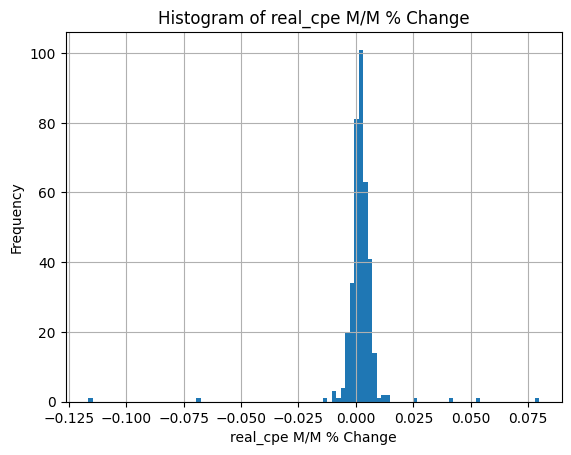

In [ ]:
# Plot histogram
df["M/M%_RCPE"].hist(bins=100)

# Add labels and title
plt.xlabel("real_cpe M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "real_cpe M/M % Change")

# Show plot
plt.show()

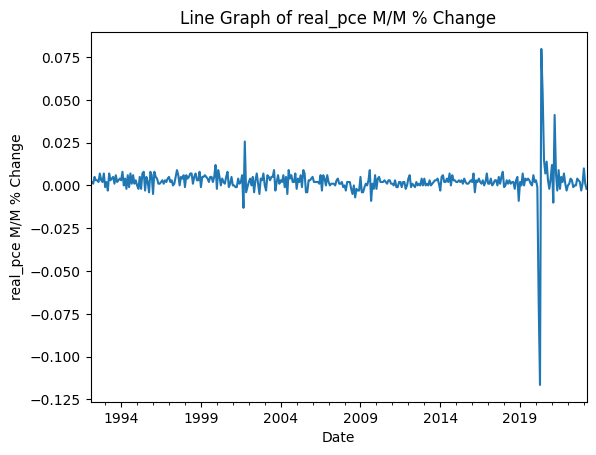

In [ ]:
# Plot histogram
df["M/M%_RCPE"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('real_pce M/M % Change')
plt.title('Line Graph of ' + "real_pce M/M % Change")

# Show plot
plt.show()

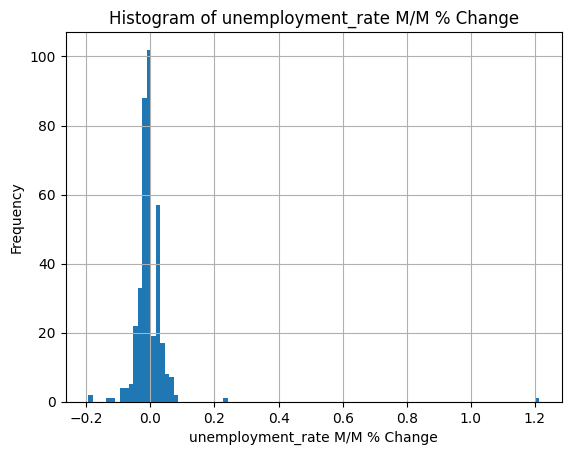

In [ ]:
# Plot histogram
df["unemployment_rate"].hist(bins=100)

# Add labels and title
plt.xlabel("unemployment_rate M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "unemployment_rate M/M % Change")

# Show plot
plt.show()

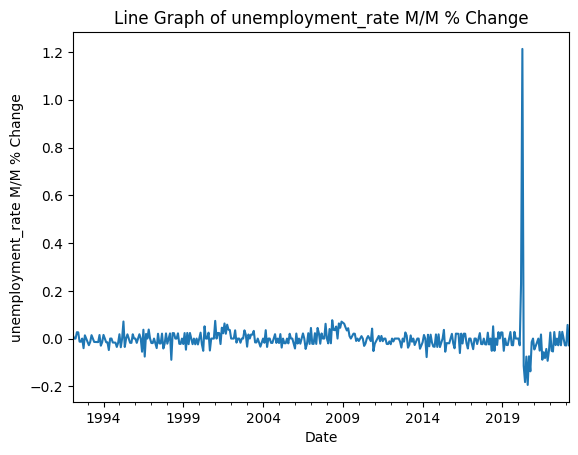

In [ ]:
# Plot histogram
df["unemployment_rate"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('unemployment_rate M/M % Change')
plt.title('Line Graph of ' + "unemployment_rate M/M % Change")

# Show plot
plt.show()

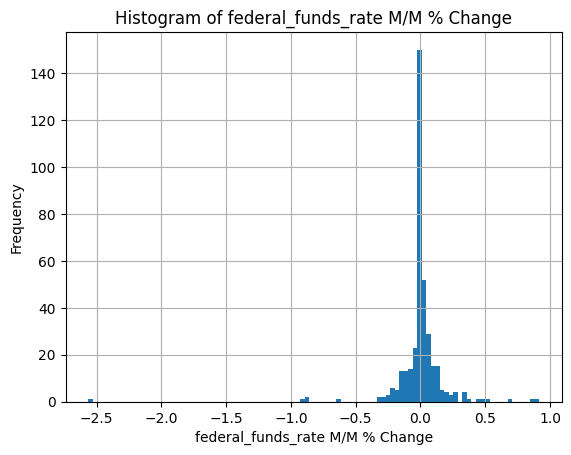

In [ ]:
# Plot histogram
df["federal_funds_rate"].hist(bins=100)

# Add labels and title
plt.xlabel("federal_funds_rate M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "federal_funds_rate M/M % Change")

# Show plot
plt.show()

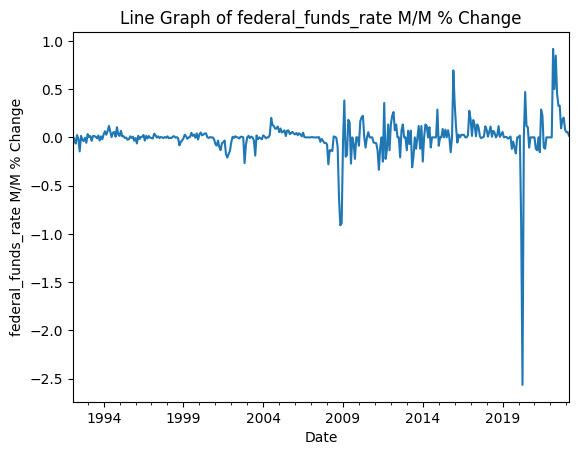

In [ ]:
# Plot histogram
df["federal_funds_rate"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('federal_funds_rate M/M % Change')
plt.title('Line Graph of ' + "federal_funds_rate M/M % Change")

# Show plot
plt.show()

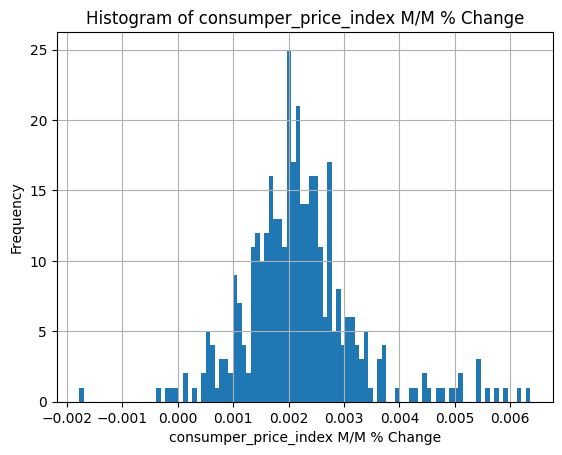

In [ ]:
# Plot histogram
df["M/M%_CPI"].hist(bins=100)

# Add labels and title
plt.xlabel("consumper_price_index M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "consumper_price_index M/M % Change")

# Show plot
plt.show()

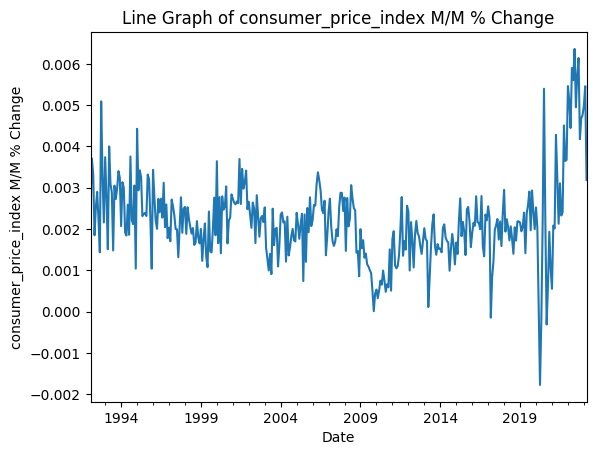

In [ ]:
# Plot histogram
df["M/M%_CPI"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('consumer_price_index M/M % Change')
plt.title('Line Graph of ' + "consumer_price_index M/M % Change")

# Show plot
plt.show()

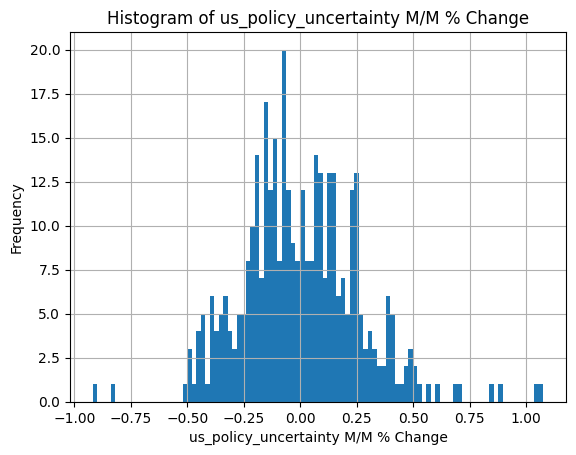

In [ ]:
# Plot histogram
df["us_policy_uncertainty"].hist(bins=100)

# Add labels and title
plt.xlabel("us_policy_uncertainty M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "us_policy_uncertainty M/M % Change")

# Show plot
plt.show()

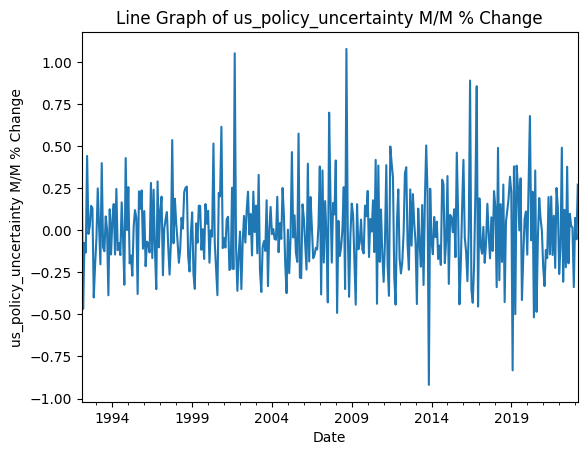

In [ ]:
# Plot histogram
df["us_policy_uncertainty"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('us_policy_uncertainty M/M % Change')
plt.title('Line Graph of ' + "us_policy_uncertainty M/M % Change")

# Show plot
plt.show()

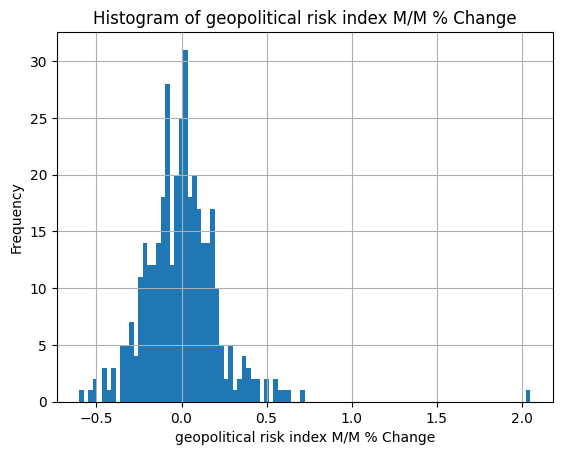

In [ ]:
# Plot histogram
df["geopolitical risk index"].hist(bins=100)

# Add labels and title
plt.xlabel("geopolitical risk index M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "geopolitical risk index M/M % Change")

# Show plot
plt.show()


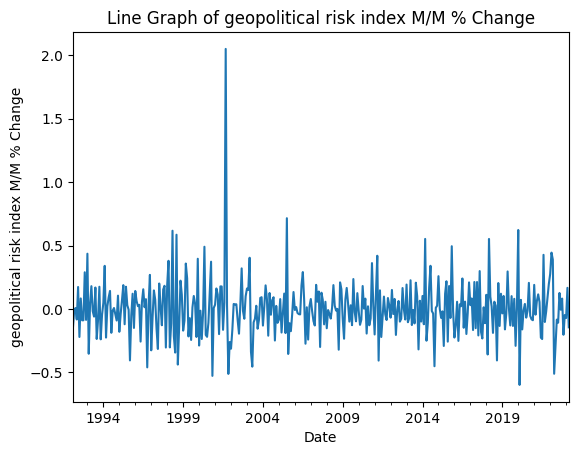

In [ ]:
# Plot histogram
df["geopolitical risk index"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('geopolitical risk index M/M % Change')
plt.title('Line Graph of ' + "geopolitical risk index M/M % Change")

# Show plot
plt.show()

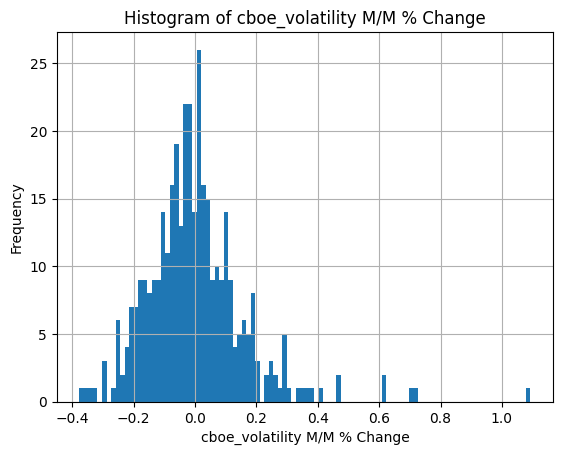

In [ ]:
# Plot histogram
df["cboe_volatility"].hist(bins=100)

# Add labels and title
plt.xlabel("cboe_volatility M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "cboe_volatility M/M % Change")

# Show plot
plt.show()

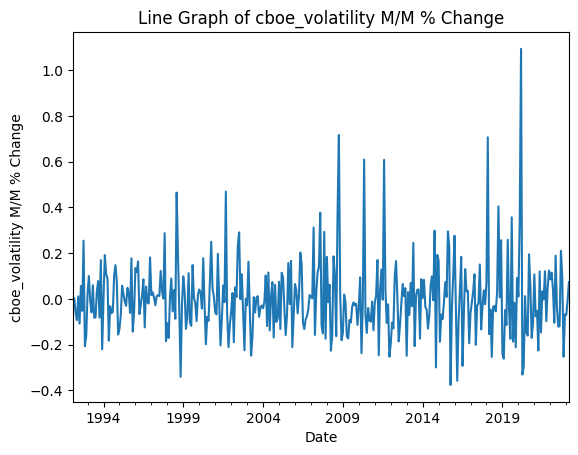

In [ ]:
# Plot histogram
df["cboe_volatility"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('cboe_volatility M/M % Change')
plt.title('Line Graph of ' + "cboe_volatility M/M % Change")

# Show plot
plt.show()

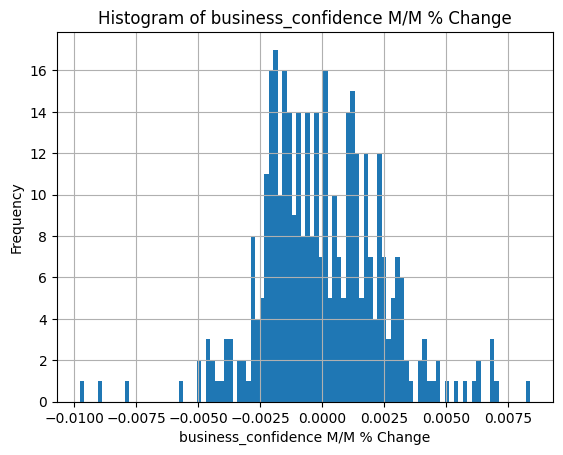

In [ ]:
# Plot histogram
df["business_confidence"].hist(bins=100)

# Add labels and title
plt.xlabel("business_confidence M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "business_confidence M/M % Change")

# Show plot
plt.show()

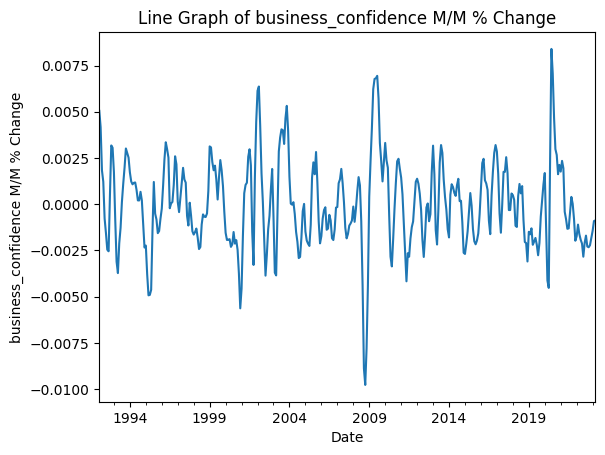

In [ ]:
# Plot histogram
df["business_confidence"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('business_confidence M/M % Change')
plt.title('Line Graph of ' + "business_confidence M/M % Change")

# Show plot
plt.show()

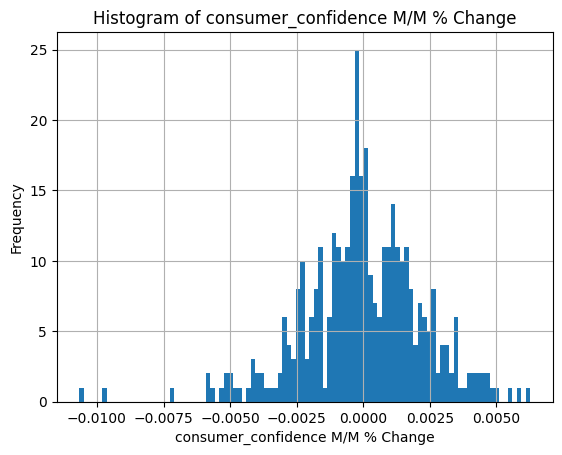

In [ ]:
# Plot histogram
df["consumer_confidence"].hist(bins=100)

# Add labels and title
plt.xlabel("consumer_confidence M/M % Change")
plt.ylabel('Frequency')
plt.title('Histogram of ' + "consumer_confidence M/M % Change")

# Show plot
plt.show()

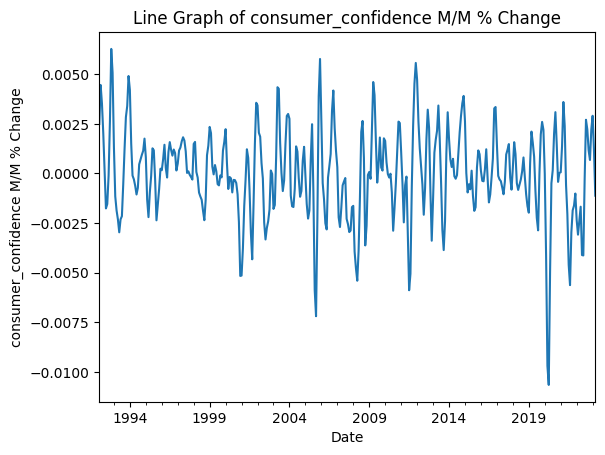

In [ ]:
# Plot histogram
df["consumer_confidence"].plot()

# Add labels and title
plt.xlabel("Date")
plt.ylabel('consumer_confidence M/M % Change')
plt.title('Line Graph of ' + "consumer_confidence M/M % Change")

# Show plot
plt.show()